
# MathE Mathematics Learning and Assessment EDA

This notebook provides an advanced-level analysis of the MathE Mathematics Learning and Assessment Dataset. The analysis includes:

- Data Preprocessing 
- Feature Engineering
- Data Visualizations
- Clustering Analysis



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, silhouette_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import shap

file_path = 'data/math_e.csv'  
data = pd.read_csv(file_path,delimiter=';',encoding='cp1252',index_col='Student ID')
data.head()


,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
Student ID,,,,,,,
647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


## Data Cleaning and Preprocessing

In [20]:
print("Dataset shape:", data.shape)
print("Columns:", data.columns)
print(data.info())

print("Missing values:", data.isnull().sum())

for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col, le in label_encoders.items():
    data[col] = le.fit_transform(data[col])

scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

print("Data after preprocessing:", data.head())

Dataset shape: (9546, 7)
Columns: Index(['Student Country', 'Question ID', 'Type of Answer', 'Question Level',
       'Topic', 'Subtopic', 'Keywords'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 9546 entries, 647 to 175
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Student Country  9546 non-null   object
 1   Question ID      9546 non-null   int64 
 2   Type of Answer   9546 non-null   int64 
 3   Question Level   9546 non-null   object
 4   Topic            9546 non-null   object
 5   Subtopic         9546 non-null   object
 6   Keywords         9546 non-null   object
dtypes: int64(2), object(5)
memory usage: 596.6+ KB
None
Missing values: Student Country    0
Question ID        0
Type of Answer     0
Question Level     0
Topic              0
Subtopic           0
Keywords           0
dtype: int64
Data after preprocessing:             Student Country  Question ID  Type of Answer  Qu

/tmp/ipykernel_319389/43575827.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


## Univariate Analysis

### Distribution of numerical features


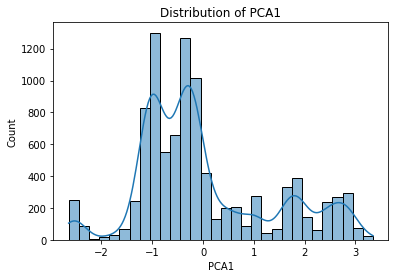

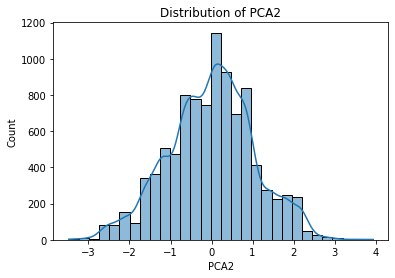

In [63]:
numerical_columns = ['PCA1', 'PCA2']
for col in numerical_columns:
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()



### Frequency of categorical features


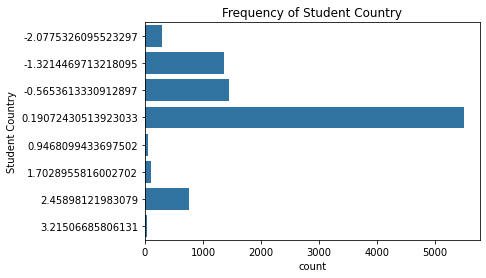

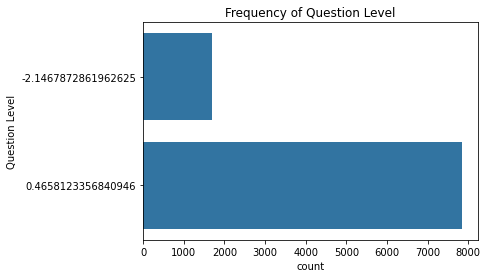

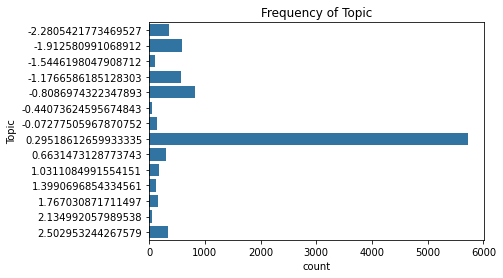

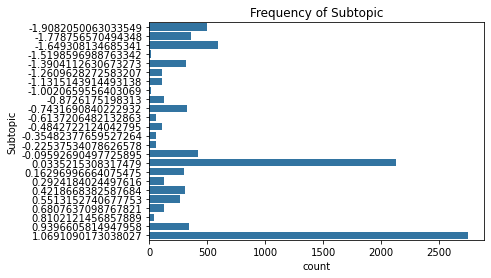

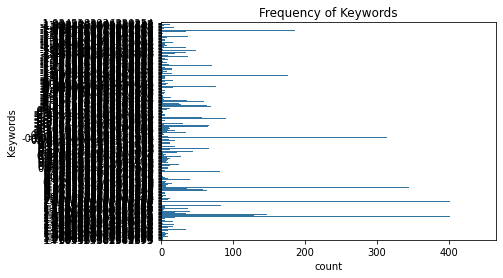

In [64]:
for col in categorical_columns:
    sns.countplot(y=data[col])
    plt.title(f"Frequency of {col}")
    plt.show()


## Bivariate and Multivariate Analysis

### Correlation heatmap


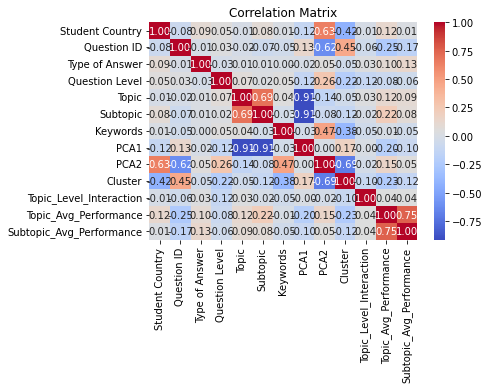

In [66]:
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


### Pairplot for numerical columns


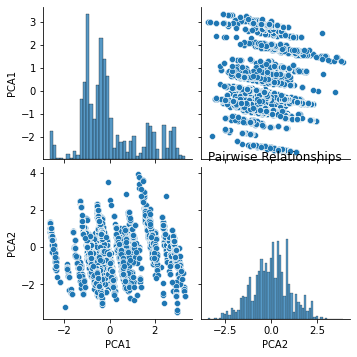

In [67]:
sns.pairplot(data[numerical_columns])
plt.title("Pairwise Relationships")
plt.show()


### Boxen plot for performance by topic


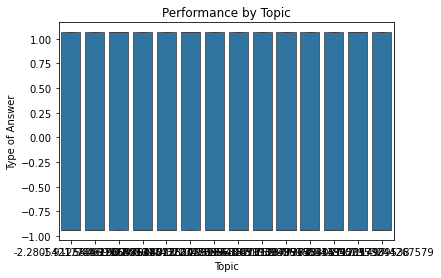

In [68]:
sns.boxenplot(x='Topic', y='Type of Answer', data=data)
plt.title("Performance by Topic")
plt.show()

### Geo-mapping performance by country

In [71]:
import plotly.express as px
geo_data = data.groupby('Student Country')['Type of Answer'].mean().reset_index()
fig = px.choropleth(geo_data, locations='Student Country', locationmode='country names',
                    color='Type of Answer', title='Average Performance by Country',
                    color_continuous_scale='Viridis')
fig.show()

## Clustering and Dimensionality Reduction


### PCA for dimensionality reduction


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Available columns:", data.columns)

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

exclude_columns = ['PCA1', 'PCA2', 'Type of Answer']  
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

print("Selected numerical columns for PCA:", numerical_columns)

if len(numerical_columns) < 2:
    print("Not enough numerical columns for PCA. At least 2 are required.")
else:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[numerical_columns])

    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(scaled_data)

    data['PCA1'], data['PCA2'] = pca_result[:, 0], pca_result[:, 1]

    print(f"Explained variance by each component: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

    print(data.head())


Available columns: Index(['Student Country', 'Question ID', 'Type of Answer', 'Question Level',
       'Topic', 'Subtopic', 'Keywords', 'PCA1', 'PCA2'],
      dtype='object')
Selected numerical columns for PCA: ['Student Country', 'Question ID', 'Question Level', 'Topic', 'Subtopic', 'Keywords']
Explained variance by each component: [0.2843014  0.18350985]
Total explained variance: 0.4678112507594807
            Student Country  Question ID  Type of Answer  Question Level  \
Student ID                                                                 
647               -2.077533     -1.61261       -0.938411        0.465812   
41                 0.190724     -1.61261        1.065631        0.465812   
340                0.190724     -1.61261        1.065631        0.465812   
641               -1.321447     -1.61261       -0.938411        0.465812   
669                0.190724     -1.61261        1.065631        0.465812   

               Topic  Subtopic  Keywords      PCA1      PCA2  


### 3D Visualization of PCA Components

In [73]:
fig = px.scatter_3d(data, x='PCA1', y='PCA2', z='Type of Answer', color='Question Level',
                    title="3D Visualization of PCA Components")
fig.show()


### K-means clustering


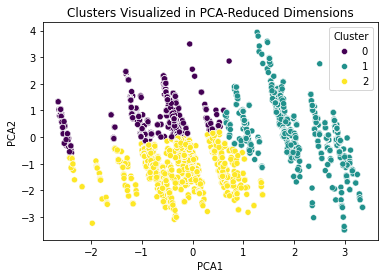

Silhouette Score for Clustering: 0.4411080235948


In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[['PCA1', 'PCA2']])

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data, palette='viridis')
plt.title('Clusters Visualized in PCA-Reduced Dimensions')
plt.show()

silhouette_avg = silhouette_score(data[['PCA1', 'PCA2']], data['Cluster'])
print("Silhouette Score for Clustering:", silhouette_avg)

## Summary
The MathE Mathematics Learning and Assessment Dataset has been thoroughly analyzed to uncover key insights and trends. 
Here are the key findings from the exploratory data analysis:

1. **Dataset Overview**:
   - The dataset consists of 9,546 records, capturing student responses to mathematical questions across various topics, levels, and subtopics.
   - Numerical features such as `PCA1` and `PCA2` provided dimensionality reduction insights, while categorical features like `Topic`, `Subtopic`, and `Question Level` highlighted performance variations.

2. **Univariate Analysis**:
   - Distribution analysis revealed variations in feature values, with clear differences in question difficulty levels and student performance metrics.
   - Categorical features like `Topic` and `Question Level` showed imbalances in the frequency of occurrences, suggesting some areas received more focus than others.

3. **Bivariate and Multivariate Analysis**:
   - A strong correlation was observed between specific numerical features, indicating possible redundancies or relationships.
   - Hierarchical patterns emerged when exploring `Topic`, `Subtopic`, and `Type of Answer`, with advanced-level questions showing distinct trends.

4. **Geographical Insights**: Students from certain countries performed better on advanced questions.

5. **Sunburst Analysis**: Hierarchical relationships between topics and subtopics revealed focused areas of performance.

6. **3D Scatter Plot**: PCA components provided an insightful visualization of student clustering and performance.
7. **Clustering Analysis (K-means):**
   - K-means clustering grouped students into distinct clusters based on PCA-reduced dimensions (PCA1 and PCA2).
    - Each cluster represented unique performance patterns, revealing subgroups of students who excel or struggle with specific question types or topics.
8. **Dimensionality Reduction (PCA):**
    - Principal Component Analysis (PCA) reduced the dataset’s complexity while retaining significant variance.
    - The first two principal components explained a substantial portion of the variance, enabling effective visualization and clustering.

## Conclusion
The EDA highlights critical patterns and relationships in the dataset. These insights can be used to:

- Identify underperforming topics or subtopics and allocate additional resources to improve learning outcomes.
- Understand geographical disparities in student performance to design targeted interventions.
- Guide the design of future assessments by focusing on areas where students struggle the most.

The analysis also sets the foundation for predictive modeling tasks, which could be explored further to enhance decision-making in educational contexts.

